In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D

from passauth import data
from passauth import utils

In [14]:
mypath = '/Users/admin/Downloads/entries/data/'
user_data = data.UserData(mypath)
print(user_data)

/Users/admin/Downloads/entries/data/; total users: 16


In [15]:
len(user_data)

16

## Plotting user behavior

When we try to draw a picture of the user behavior, we can clearly see a unique pattern to two users.


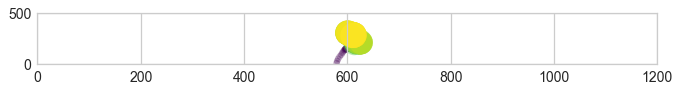

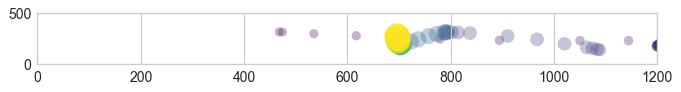

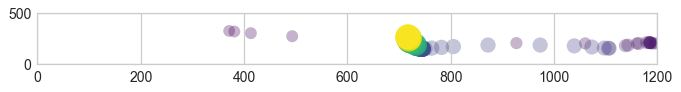

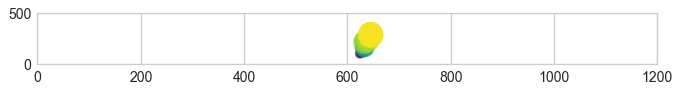

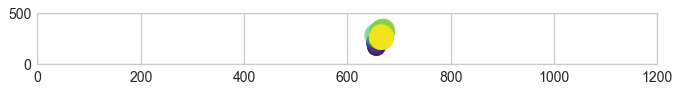

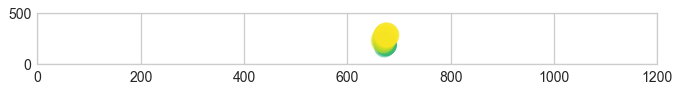

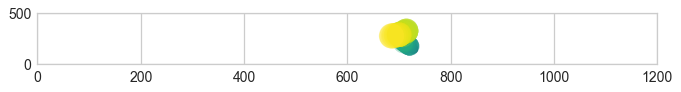

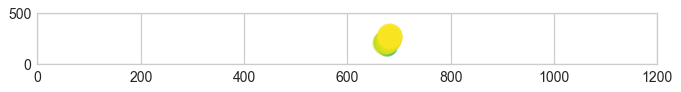

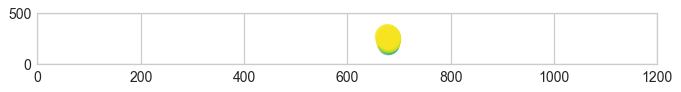

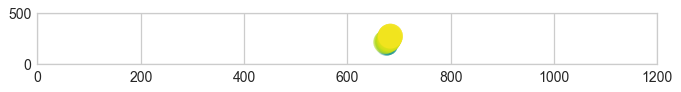

In [4]:

# Plot user 1
user1 = user_data.getUserData(1)
utils.plotUserMouseScatterMultiple(user1, n=10)

In [ ]:
# Plot user 2
user2 = getUserData(2)
plotUserMouseScatterMultiple(user2, n=6)

## Time for some Machine Learning

'After some failed attempts at one-shot learning using deep NNs'

In [16]:
def pad(arr, n):
    """
    If arr is not equal to n in length, fill it with zero
    
    >>>pad([1, 1], 5)
    [1, 1, 1, 1, 1]
    """
    if n < len(arr):
        arr = arr[:n]
        
    else:
        arr = arr + ((n-len(arr)) * [[0,0,0]])
        
    return arr
   

# Read all the files backed up from the server

data = []
for i in range(len(user_data)):
    data.append(user_data.getUserData(i))


In [6]:
help(pad)

Help on function pad in module __main__:

pad(arr, n)
    If arr is not equal to n in length, fill it with zero
    
    >>>pad([1, 1], 5)
    [1, 1, 1, 1, 1]



In [17]:
# Filter all files that have at least 20 login attempts
data = list(filter(lambda x: len(x) >= 20, data))

In [18]:
# Wrangle and extract the mouse movements

data = [[pad(each['mouseMovements'],n=200), user] for user in range(len(data))
    for each in data[user]]

In [19]:
# Separate training cases and class labels
dataX = []
dataY = []

for each in data:
    dataX.append(each[0])
    dataY.append(each[1])


In [21]:
# numpy is much better for remainder of the steps than python lists
dataX = np.array(dataX)
dataX = dataX.reshape(161, 600)
dataY = np.array(dataY)
dataY = dataY.reshape(len(dataY),)

### Multiple ML algorithm results

In [22]:
import sklearn as sk
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split

# training set = 63% and testing set = 33%
X_train, X_test, y_train, y_test = train_test_split(
    dataX, dataY, test_size=0.33, random_state=30)


### SUPPORT VECTOR MACHINES

In [23]:
SVM = svm.LinearSVC()
print(SVM)
SVM = SVM.fit(X_train, y_train)
print(f"Simple SVM: {SVM.score(X_test, y_test)}")

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Simple SVM: 0.2962962962962963


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# One versus one is actually giving very poor performance. Why?
# Probably the classes themselves are not very different o vs o
clf = svm.SVC(decision_function_shape='ovo')
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)


Some engineering with SVM actually gives a very good performance.

In [ ]:
# Implement binary discriminator
import random
for each in range(len(np.unique(y_train))):
    _SVM = svm.SVC( degree=5)
    _y_train = y_train.copy()
    _y_test = y_test.copy()
    _SVM.fit(X_train, np.where(_y_train != each, -1, each))
    res = _SVM.predict(X_test)
    print(f"Score for User {each}:\nAccuracy: {_SVM.score(X_test, np.where(_y_test != each, -1, each))}")
    
    FAR = [(real != each) and (guess == each) for real,guess in zip(_y_test, res)].count(True)
    FRR = [(real == each) and (guess != each) for real,guess in zip(_y_test, res)].count(True)
    
    print(f"FAR: {FAR/len(_y_test)} and FRR: {FRR/len(_y_test)}\n")

In [ ]:
# Implement binary discriminator
for each in range(len(np.unique(y_train))):
    _SVM = svm.SVC(kernel='rbf')
    _y_train = y_train.copy()
    _y_test = y_test.copy()
    _SVM.fit(X_train, np.where(_y_train != each, -1, each))
    res = _SVM.predict(X_test)

    print(f"Score for User {each}:\nAccuracy: {_SVM.score(X_test, np.where(_y_test != each, -1, each))}")
    
    FAR = [(real != each) and (guess == each) for real,guess in zip(_y_test, res)].count(True)
    FRR = [(real == each) and (guess != each) for real,guess in zip(_y_test, res)].count(True)
    
    print(f"FAR: {FAR/len(_y_test)}, total instances = {list(np.where(_y_test != each, -1, 0)).count(-1)}")
    print(f"FRR: {FRR/len(_y_test)}, total instances = {list(np.where(_y_test == each, each, -1)).count(each)}\n")

## DECISION TREES
Performance above 0.5 without any feature engineering is actually great. Random guessing would give only 0.15

In [ ]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)
decision_tree.score(X_test, y_test)

## RANDOM FOREST
An ensemble random forest (without any feature engineering) is improving upon the decision tree results- a good sign that things can be improved.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

### GRADIENT BOOS CLASSIFIER 
good for hypothesis testing :)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=40,
                                learning_rate=1.0)
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

In [ ]:
biometric = Biometric(['mouse', 'keyboard'])

## Feature Engineering

1. Calculate the center.
2. Calculate the directions.
3. Bag the events into 4-8 directions.

# Calculate the Quadrants:
```
   \  8 |  1 /         
     \  |  /  2
_______\|/______
   6   /|\  3
     /  |4 \
   /    |    \
```

In [ ]:
def degree(x, y, center):
    """
    returns the degree 0-360 for a given x,y and center(x,y)
    """
    x -= center[0]
    y -= center[1]
    degrees = math.degrees(math.atan2(y, x))
  
    if degrees < 0:
        return 360+degrees
    return degrees

In [ ]:
cols = ['user', 'attempt', 'x', 'y', 'timestamp']
data = []

for each in range(len(onlyfiles)):
    res = getUserData(each)
    if len(res)>= 20:
        for attempt in range(len(res)):
            for event in res[attempt]['mouseMovements']:
                data.append([each, attempt] + event)

In [ ]:
data = pd.DataFrame(data, columns=cols)

In [ ]:
data.groupby(['user', 'attempt']).mean()